# Homework 2

## Download Dataset

In [147]:
!curl -o homework_2/car_fuel_efficiency.csv https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  853k  100  853k    0     0  3050k      0 --:--:-- --:--:-- --:--:-- 3048k


## Preparing the dataset

In [148]:
import pandas as pd
import numpy as np

In [149]:
data = pd.read_csv('homework_2/car_fuel_efficiency.csv')
features = ['engine_displacement', 'horsepower', 'vehicle_weight', 'model_year', 'fuel_efficiency_mpg']
data = data[features]

Look at 'fuel_efficiency_mpg'. Does it have a long tail?

In [150]:
import seaborn as svs
import matplotlib.pyplot as plt
%matplotlib inline

<Axes: xlabel='fuel_efficiency_mpg', ylabel='Count'>

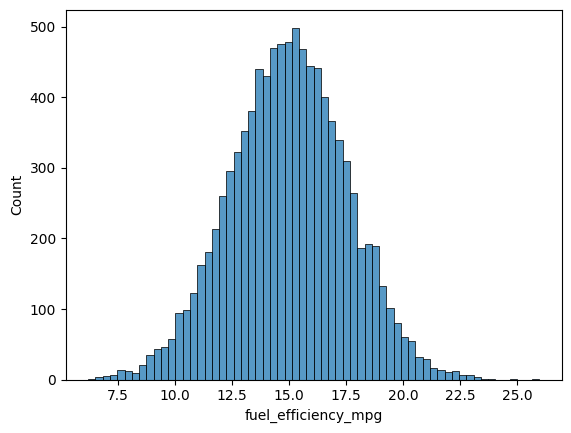

In [151]:
svs.histplot(data.fuel_efficiency_mpg)

No, it does not seem like there is a long tail in the response variable

## Q1. There's one column with missing values. What is it?

In [152]:
data.isnull().sum()
missing = data.isnull().sum()[data.isnull().sum() != 0]
print(np.array(missing.index), 'has ', missing.values,'missing values')

['horsepower'] has  [708] missing values


## Q2. What's the median (50% percentile) for variable 'horsepower'?

In [153]:
np.nanmedian(data['horsepower'])
data['horsepower'].median(skipna=True)

149.0

## Prepare and split the dataset
1. shuffle the dataset (the filtered one you created above), use seed 42
2. split your data in train/val/test sets, with 60%/20%/20% distribution

In [154]:
np.random.seed(42)

n = len(data)
n_val = int(n*0.2)
n_test = int(n*0.2)
n_train = n - (n_val + n_test)

idx = np.arange(n)
np.random.shuffle(idx)

data_shuffled = data.iloc[idx]

data_train = data_shuffled.iloc[0:n_train].reset_index(drop = True)
data_val = data_shuffled.iloc[n_train:n_train+n_val].reset_index(drop = True)
data_test = data_shuffled.iloc[n_train+n_val:].reset_index(drop = True)

y_train = data_train['fuel_efficiency_mpg']
y_val = data_val['fuel_efficiency_mpg']
y_test = data_test['fuel_efficiency_mpg']

del data_train['fuel_efficiency_mpg']
del data_test['fuel_efficiency_mpg']
del data_val['fuel_efficiency_mpg']

## Q3.
* We need to deal with missing values for the column from Q1
* We have two options: fill it with 0 or wil the mean of this variable
* Try both options. For each, train a linear regression model without regularization using the code from the lessons
* For computing the mean, use the training only!
* Use the validation dataset to evaluate the models and compare the RMSE of each option
* Round the RMSE scored to 2 decimal digits using round(score, 2)
* Which option gives better RMSE?

In [155]:
# Takes the mean of horsepower only from the training data
mean_hp_train = data_train['horsepower'].mean(skipna = True)

# functions to fill missing values in horsepower and extract the matrices
def prepare_X_mean(df):
    df = df.copy()
    df['horsepower'] = df['horsepower'].fillna(mean_hp_train)
    X = df.values
    return(X)

X_train_mean = prepare_X_mean(data_train)
X_test_mean = prepare_X_mean(data_test)
X_val_mean = prepare_X_mean(data_val)

def prepare_X_zero(df):
    df = df.copy()
    df['horsepower'] = df['horsepower'].fillna(0)
    X = df.values
    return(X)

X_train_zero = prepare_X_zero(data_train)
X_test_zero = prepare_X_zero(data_test)
X_val_zero = prepare_X_zero(data_val)

# function to calculate the weights for the linear regression (training)
def train_linreg(X,y):
    ones = np.ones(X.shape[0]) # Creates a column of ones to be used as coefficient for bias weight
    X = np.column_stack([ones, X]) # Adds the created column as the first column in X

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    return w[0], w[1:]

# Function to calculate the RMSE
def rmse(y,y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    rmse = np.sqrt(mse)
    return rmse

# weights from linear regression with mean
w_mean_0, w_mean = train_linreg(X_train_mean, y_train)
y_val_pred_mean = w_mean_0 + X_val_mean.dot(w_mean)
rmse_mean = rmse(y_val, y_val_pred_mean).round(2)

# weights from linear regression with zero
w_zero_0, w_zero = train_linreg(X_train_zero, y_train)
y_val_pred_zero = w_zero_0 + X_val_zero.dot(w_zero)
rmse_zero = rmse(y_val, y_val_pred_zero).round(2)

print('The RMSE base on mean is ', rmse_mean, ', while the one based on filling missing values with 0 is ', rmse_zero)

The RMSE base on mean is  0.46 , while the one based on filling missing values with 0 is  0.52


## Q4.
* Now let's train a regularized linear regression
* For this question, fill the NAs with 0
* Try different values of r from this list: [0, 0.01, 0.1, 1, 5, 10, 100]
* Use RMSE to evaluate the model on the validation dataset
* Round the RMSE scores to 2 decimal digits
* Which r gives the best RMSE?

In [156]:
r = [0, 0.01, 0.1, 1, 5, 10, 100]
# function for regularized linear regression
def train_linreg_regularized(X,y,r):
    ones = np.ones(X.shape[0]) # Creates a column of ones to be used as coefficient for bias weight
    X = np.column_stack([ones, X]) # Adds the created column as the first column in X

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0]) # this adds regularized terms at the diagnoal of XTX
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    return w[0], w[1:]

for r in r:
    w_reg_0, w_reg = train_linreg_regularized(X_train_zero, y_train, r)
    y_val_reg = w_reg_0 + X_val_zero.dot(w_reg)
    rmse_reg = rmse(y_val, y_val_reg).round(2)
    print('r =',r,', w0 =', w_reg_0, ', rmse = ', rmse_reg)



r = 0 , w0 = 28.82736547437522 , rmse =  0.52
r = 0.01 , w0 = 24.926838419651713 , rmse =  0.52
r = 0.1 , w0 = 11.239661084720263 , rmse =  0.52
r = 1 , w0 = 1.731597941154011 , rmse =  0.52
r = 5 , w0 = 0.36380750205483864 , rmse =  0.52
r = 10 , w0 = 0.18306246621703365 , rmse =  0.52
r = 100 , w0 = 0.018418017307219765 , rmse =  0.52


## Q5.
* We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score
* Try different seed values:[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
* For each seed, do the train/validation/test split with 60/20/20
* Fill the missing values with 0 and train a model without regularization
* For each seed, evaluate the model on the validation dataset and collect the rmse scores
* What is the standard deviation of all the scores? To compute the standard deviation, use np.std
* Round the results to 3 decimal digits

In [157]:
seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
scores = []
for seed in seeds:
    np.random.seed(seed)
    idx = np.arange(n)
    np.random.shuffle(idx)

    data_shuffled = data.iloc[idx]

    data_train = data_shuffled.iloc[0:n_train].reset_index(drop = True)
    data_val = data_shuffled.iloc[n_train:n_train+n_val].reset_index(drop = True)
    data_test = data_shuffled.iloc[n_train+n_val:].reset_index(drop = True)

    y_train = data_train['fuel_efficiency_mpg']
    y_val = data_val['fuel_efficiency_mpg']
    y_test = data_test['fuel_efficiency_mpg']

    del data_train['fuel_efficiency_mpg']
    del data_test['fuel_efficiency_mpg']
    del data_val['fuel_efficiency_mpg']

    X_train_zero = prepare_X_zero(data_train)
    X_test_zero = prepare_X_zero(data_test)
    X_val_zero = prepare_X_zero(data_val)

    # weights from linear regression with zero
    w_zero_0, w_zero = train_linreg(X_train_zero, y_train)
    y_val_pred_zero = w_zero_0 + X_val_zero.dot(w_zero)
    rmse_zero = rmse(y_val, y_val_pred_zero)
    scores.append(rmse_zero)

print('The standard deviation of the RMSE is', np.std(scores).round(3))

The standard deviation of the RMSE is 0.007


# Q6.
* Split the dataset like previously, use seed 9
* Combine train and validation datasets
* Fill the missing values with 0 and train a model with regularization r = 0.001
* What is the RMSE on the test dataset?

In [158]:
np.random.seed(9)
idx = np.arange(n)
np.random.shuffle(idx)

data_shuffled = data.iloc[idx]

n_train = n_train + n_val

data_train = data_shuffled.iloc[0:n_train].reset_index(drop = True)
data_test = data_shuffled.iloc[n_train:].reset_index(drop = True)

y_train = data_train['fuel_efficiency_mpg']
y_test = data_test['fuel_efficiency_mpg']

del data_train['fuel_efficiency_mpg']
del data_test['fuel_efficiency_mpg']

X_train_zero = prepare_X_zero(data_train)
X_test_zero = prepare_X_zero(data_test)

# weights from linear regression with zero
w_zero_0, w_zero = train_linreg_regularized(X_train_zero, y_train, r = 0.001)
y_test_pred_zero = w_zero_0 + X_test_zero.dot(w_zero)
rmse_test = rmse(y_test, y_test_pred_zero)

print('The RMSE on the test set is', rmse_test)

The RMSE on the test set is 0.515626129917388
